In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from activ import load_data
from activ.cca.alscca import TALSCCA
from activ.cca import cross_decomp_scatter
from activ.viz import multi_stemplot

from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.utils import check_random_state

from scipy.stats import pearsonr

In [2]:
data = load_data()
bm = data.biomarkers
oc = data.outcomes
gcs_simple = bm[:, np.where(data.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
random_state = check_random_state(1000)
bm, oc = scale(bm), scale(oc)

In [3]:
grid = ParameterGrid({'max_iters':[1000], 'n_components': [3, 4, 5], 'alpha_x': 10.0**(-1*np.arange(1, 5)), 'alpha_y': 10.0**(-1*np.arange(1,5))})

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=random_state)

In [5]:
import warnings

with warnings.catch_warnings(record=False):
    warnings.simplefilter('ignore')

    scores = np.zeros((cv.n_splits, len(grid)))

    for i, (train, test) in enumerate(cv.split(bm, gcs_simple)):
        X_train, Y_train = bm[train], oc[train]
        X_test, Y_test = bm[test], oc[test]

        for j, params in enumerate(grid):
            talscca = TALSCCA(**params).fit(X_train, Y_train)
            X_cca, Y_cca = talscca.transform(X_test, Y_test)
            scores[i, j] = pearsonr(X_cca.flatten(), Y_cca.flatten())[0]

In [6]:
best_params = grid[np.argmax(scores.mean(axis=0))]
print(best_params)

{'n_components': 3, 'max_iters': 1000, 'alpha_y': 0.01, 'alpha_x': 0.1}


In [7]:
k = best_params['n_components']
_best_params = best_params.copy()
_best_params['max_iters'] = 2000
talscca = TALSCCA(**_best_params)
cv_bm, cv_oc = talscca.fit_transform(bm, oc)
talscca.n_iters_

2000

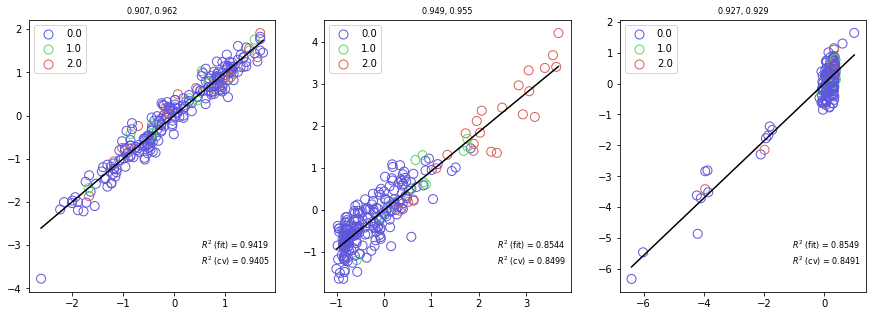

In [8]:
plt.figure(figsize=(15,5))
for i in range(k):
    plt.subplot(1, k, i+1)
    x = cv_bm[:,i]
    y = cv_oc[:, i]
    title = "%0.3f, %0.3f" % (x.var(), y.var())
    cross_decomp_scatter(x, y, fontsize=8, labels=gcs_simple, title=title)

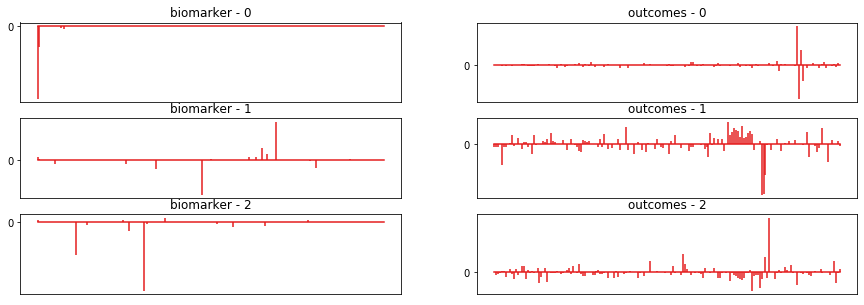

In [9]:
plt.figure(figsize=(15,5))
for i in range(k):
    plt.subplot(k, 2, i*2+1)
    multi_stemplot(talscca.X_components_[i])
    plt.title('biomarker - %d'%i)
    plt.subplot(k, 2, i*2+2)
    plt.title('outcomes - %d'%i)
    multi_stemplot(talscca.Y_components_[i])

In [ ]:
Cxx = bm.T.dot(bm)
Cyy = oc.T.dot(oc)

In [ ]:
for i in range(k):
    plt.subplot(1, k, i+1)
    x = talscca.X_components_[i]
    y = talscca.Y_components_[i]
    print(x.dot(Cxx.dot(x)), y.dot(Cyy.dot(y)))

In [ ]:
talscca.X_components_.dot(Cxx.dot(talscca.X_components_.T))

In [ ]:
np.linalg.norm(talscca.X_components_, axis=1)

In [ ]:
multi_stemplot(coef_oc.T)

In [ ]:
coef_oc.T.dot(coef_oc)

In [ ]:
coef_oc[:,0].dot(coef_oc[:,0])

In [ ]:
cross_decomp_scatter(cv_bm[:,1], cv_oc[:, 2])

In [ ]:
coef_oc